In [9]:
%matplotlib inline
from __future__ import print_function
import argparse, gzip, cPickle, sys, time, itertools

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
import autograd.scipy.stats.dirichlet as dirichlet
from autograd.scipy.misc import logsumexp
from autograd.util import flatten_func, flatten
from autograd import grad, primitive
from autograd.numpy.numpy_grads import unbroadcast

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn import mixture

from  autograd.scipy.special import gammaln, digamma, gamma
from scipy import linalg
from scipy import stats, integrate

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import pandas as pd
import six



color_names =  ["windows blue",
               "red",
               "gold",
               "grass green",
               "orange", "yellow", "cornflower", "dark red", "dark blue", "brown"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")

color_iter = itertools.cycle(colors)

def plot_results(ax, X, Y, means, covariances, index, title):
    #splot = ax.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
             means, covariances, color_iter)):
        v, w = linalg.eigh(np.diag(np.full([2], covar)))
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])      

        if not np.any(Y == i):
            continue
        ax.scatter(X[Y == i, 0], X[Y == i, 1], 2., color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        #ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        

class Adam(object):
    def __init__(self, dparam, b1=0.9, b2=0.999, eps=1,#10**-8,
                         decay_rate = 0.9, decay_steps = 100):                    
        self.b1 = b1;
        self.b2 = b2;
        self.eps = eps        
        self.m = np.zeros(dparam)
        self.v = np.zeros(dparam)
        self.i = 0
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
    
    def update(self, gradients, params, learning_rate = 0.1):        
        self.i = self.i+1
        step_size = learning_rate * self.decay_rate**(self.i/self.decay_steps)        
        self.m = (1 - self.b1) * gradients + self.b1 * self.m
        self.v = (1 - self.b2) * (gradients**2) + self.b2 * self.v
        mhat = self.m / (1 - self.b1**(self.i))
        vhat = self.v / (1 - self.b2**(self.i))                        
        params = params + step_size*mhat/(np.sqrt(vhat) + self.eps)        
        return np.split(params,2)

    
@primitive
def softplus(x):
    return np.log(1. + np.exp(x))

softplus.defvjp(lambda g, ans, vs, gvs, x: unbroadcast(vs, gvs, g * 1./(1. + np.exp(-x))))

def jacobian_softplus(x):
    return 1./(1. + np.exp(-x))

@primitive
def gamma_logpdf(x, alpha = 1., beta = 1.):
    return  (alpha*np.log(beta) + (alpha - 1)*np.log(x) - x*beta - gammaln(alpha))

gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs, g * ((alpha-1)/x - beta)))
gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs,  g * (np.log(beta) + np.log(x) - digamma(alpha))), argnum=1)
gamma_logpdf.defvjp(lambda g, ans, vs, gvs, x, alpha=1.0, beta=1.0: unbroadcast(vs, gvs,  g * (alpha/beta - x)), argnum=2)

In [180]:
class LinearRegression(object):
    def __init__(self, data, scale):
        self.data = data             
        self.scale = scale
        self.N = data['x'].shape[0]
        self.D = data['x'].shape[1]        
    
    def p_log_prob(self, idx, z):
        x, y = self.data['x'][idx], self.data['y'][idx]
        w, tau, alpha = z['w'], softplus(z['tau']), softplus(z['alpha'])
        log_prior = 0.
        log_prior += np.sum(gamma_logpdf(tau, 1e-3, 1e-3) + np.log(jacobian_softplus(z['tau'])))        
        log_prior += np.sum(gamma_logpdf(alpha, 1e-3, 1e-3) + np.log(jacobian_softplus(z['alpha'])))        
        log_prior += np.sum(norm.logpdf(w, 0, 1./np.sqrt(alpha)))        
        log_lik = np.sum(norm.logpdf(y, np.matmul(x, w), 1./np.sqrt(tau)))
        return self.scale * log_lik + log_prior                
 
    def q_log_prob(self, means, log_sigmas, z):
        q_w = np.sum(norm.logpdf(z, means, np.exp(log_sigmas)))        
        return q_w
      
    def q_log_prob_sep(self, means, log_sigmas, z):
        q_w = norm.logpdf(z, means, np.exp(log_sigmas))        
        return q_w
    
    def sample_q(self, means, log_sigmas, d):        
        eps = npr.randn(d)        
        q_s = np.exp(log_sigmas) * eps + means
        return (q_s, eps)
        
    def grad_params(self, dp_log_prob, eps, log_sigmas):                
        grad_means = dp_log_prob
        grad_log_sigmas = dp_log_prob*eps*np.exp(log_sigmas) + 1                
        return np.concatenate([grad_means, grad_log_sigmas])
        
    def calc_eps(self, means, log_sigma, z):        
        eps  = (z - means)/np.exp(log_sigma)
        return eps            

In [181]:
class Inference(object):      
    def __init__(self, model, params):
        self.model = model
        self.params = params

    def run(self, epochs, batch_size, samples, learning_rate, algorithm = 'SGD', optimizer = 'adam'):
        epochs = epochs
        batches = self.model.N/batch_size
        batch_size = batch_size
        samples = samples
        learning_rate = learning_rate        
        
        means, unflatten = flatten(self.params['means'])
        log_sigmas, unflatten = flatten(self.params['log_sigmas'])        
        D =len(means)

        self.F = np.zeros(epochs * batches)
        self.time = np.zeros(epochs * batches)
        adam = Adam(2*D)
        f = 0
        
        grad_p_log_prob = grad(model.p_log_prob, argnum = 1)
        grad_q_log_prob = grad(model.q_log_prob, argnum = 1)
        
        if algorithm == 'SGD':
            for e in range(epochs):
                for b in range(batches): 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.
                    idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                    
                    d_elbo = 0.

                    for s in range(samples):
                        eps = npr.randn(D)        
                        z = np.exp(log_sigmas) * eps + means                                            
                        p_log_prob = model.p_log_prob(idx, unflatten(z))                        
                        dp_log_prob, _ = flatten(grad_p_log_prob(idx, unflatten(z)))
                        g =  model.grad_params(dp_log_prob, eps, log_sigmas)                        
                        d_elbo += g
                        q_log_prob = model.q_log_prob(means, log_sigmas, z)                                         
                        losses +=  (p_log_prob - q_log_prob)                    
                    loss = losses/samples
                    d_elbo /= samples                       
                    means, log_sigmas = adam.update(d_elbo, np.concatenate([means, log_sigmas]), learning_rate)                    
                    self.F[f] =  -loss                

                    stop = time.clock()
                    self.time[f] = stop - start
                    f+=1
                if e % 1 == 0:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])
                    print (pstate, end = '\r')
                    sys.stdout.flush()    
                    
                            
        if algorithm == 'iSGD':
            n = 1.  
            z_old = [0.] * samples
            dp_log_prob_old = [0.] * samples
            q_log_prob_old = [0.] * samples            

            for e in range(epochs):
                for b in range(batches): 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.
                    idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                                                            
                    if n > .7:
                        for s in range(samples):
                            eps = npr.randn(D)        
                            z = np.exp(log_sigmas) * eps + means
                            p_log_prob = model.p_log_prob(idx, unflatten(z))
                            q_log_prob = model.q_log_prob_sep(means, log_sigmas, z)                                         
                            dp_log_prob, _ = flatten(grad_p_log_prob(idx, unflatten(z)))
                            g =  model.grad_params(dp_log_prob, eps, log_sigmas)                        
                            d_elbo += g
                            losses +=  (p_log_prob - np.sum(q_log_prob))
                                        
                            z_old[s] = z
                            dp_log_prob_old[s] = dp_log_prob
                            q_log_prob_old[s] = q_log_prob                            

                        loss = losses/samples
                        d_elbo /= samples                                            
                    else:                         
                        for s in range(samples):                            
                            eps = (z_old[s] - means)/np.exp(log_sigmas)                            
                            q_log_prob = model.q_log_prob_sep(means, log_sigmas, z_old[s])                                         
                            w = np.exp(q_log_prob - q_log_prob_old[s])                            
                            g =  model.grad_params(w * dp_log_prob_old[s], eps, log_sigmas)                        
                            d_elbo += g                            
                        d_elbo /= samples                                             
                    n = npr.uniform()                    
                    means, log_sigmas = adam.update(d_elbo, np.concatenate([means, log_sigmas]), learning_rate)                    
                    self.F[f] =  -loss                
                    stop = time.clock()
                    self.time[f] = stop - start
                    f+=1                    
                if e % 1 == 0:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])
                    print (pstate, end = '\r')
                    sys.stdout.flush()  
                                        
        if algorithm == 'iSRA':
            n = 1.  
            alpha = .6
            z_old = [0.] * samples
            dp_log_prob_old = [0.] * samples
            q_log_prob_old = [0.] * samples            
            d_elbo_avg = 0.
            for e in range(epochs):
                for b in range(batches): 
                    start = time.clock()
                    losses = 0.
                    d_elbo = 0.
                    idx = np.random.choice(np.arange(self.model.N), batch_size, replace=False)                                                            
                    if n > .7:
                        for s in range(samples):
                            eps = npr.randn(D)        
                            z = np.exp(log_sigmas) * eps + means
                            p_log_prob = model.p_log_prob(idx, unflatten(z))
                            q_log_prob = model.q_log_prob_sep(means, log_sigmas, z)                                         
                            dp_log_prob, _ = flatten(grad_p_log_prob(idx, unflatten(z)))
                            g =  model.grad_params(dp_log_prob, eps, log_sigmas)                        
                            d_elbo += g
                            losses +=  (p_log_prob - np.sum(q_log_prob))
                                        
                            z_old[s] = z
                            dp_log_prob_old[s] = dp_log_prob
                            q_log_prob_old[s] = q_log_prob                            

                        loss = losses/samples
                        d_elbo /= samples                                                                    
                        d_elbo_avg = alpha*d_elbo + (1 - alpha)*d_elbo_avg
                    else:                         
                        for s in range(samples):                            
                            eps = (z_old[s] - means)/np.exp(log_sigmas)                            
                            q_log_prob = model.q_log_prob_sep(means, log_sigmas, z_old[s])                                         
                            w = np.exp(q_log_prob - q_log_prob_old[s])                            
                            g =  model.grad_params(w * dp_log_prob_old[s], eps, log_sigmas)                        
                            d_elbo += g                            
                        d_elbo /= samples                                             
                        d_elbo_avg = alpha*d_elbo + (1 - alpha)*d_elbo_avg
                    n = npr.uniform()                                        
                    means, log_sigmas = adam.update(d_elbo_avg, np.concatenate([means, log_sigmas]), learning_rate)                    
                    self.F[f] =  -loss                
                    stop = time.clock()
                    self.time[f] = stop - start
                    f+=1                    
                if e % 1 == 0:
                    pstate = 'Epoch = ' + "{0:0=3d}".format(e) + ': Loss = {0:.3f}'.format(self.F[f-1])
                    print (pstate, end = '\r')
                    sys.stdout.flush()  
                    
        self.params = {'means': unflatten(means), 'log_sigmas': unflatten(log_sigmas)}

In [182]:
#Parameters
N = 10000
K = 5
D = 1
x = 5*npr.randn(N*K).reshape([N,K]) + 10
alpha = np.ones(K)
#lpha[:5] = #
w = npr.normal(0, 1./np.sqrt(alpha))
y = np.matmul(x, w) + npr.randn(N)
data = {}
data['x'] = x
data['y'] = y

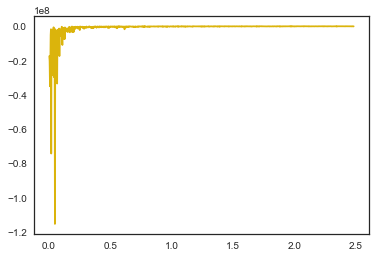

In [183]:
batch_size = 1000
seed = 111
learning_rate = 0.1
samples = 1
epochs = 100

model = LinearRegression(data, N/batch_size) 
sns.set_style(style='white')
npr.seed(seed)    
params = {}
params['means'] = {'w': 10 * npr.randn(K), 'alpha':  npr.randn(K), 'tau': npr.randn(1)}
params['log_sigmas'] = {'w': npr.randn(K), 'alpha': .1 * npr.randn(K), 'tau': npr.randn(1)}
inference = Inference(model, params)  
inference.run(epochs, batch_size, samples, learning_rate, 'SGD')
plt.plot(np.cumsum(inference.time), -inference.F, color = colors[2])


# model = LinearRegression(data, N/batch_size) 
# sns.set_style(style='white')
# npr.seed(seed)    
# params = {}
# params['means'] = {'w': npr.randn(K), 'alpha': .1* npr.randn(K), 'tau': npr.randn(1)}
# params['log_sigmas'] = {'w': npr.randn(K), 'alpha': .1 * npr.randn(K), 'tau': npr.randn(1)}
# inference = Inference(model, params)  
# inference.run(epochs, batch_size, samples, learning_rate, 'iSGD')
# plt.plot(np.cumsum(inference.time), -inference.F, color = colors[0])

# model = LinearRegression(data, N/batch_size) 
# sns.set_style(style='white')
# npr.seed(seed)    
# params = {}
# params['means'] = {'w': npr.randn(K), 'tau': npr.randn(1)}
# params['log_sigmas'] = {'w': npr.randn(K), 'tau': npr.randn(1)}
# inference = Inference(model, params)  
# inference.run(epochs, batch_size, samples, learning_rate, 'iSRA')
# plt.plot(np.cumsum(inference.time), -inference.F, color = colors[1])

# npr.seed(seed)    
# params = {}
# params['means'] = {'mu': np.ones(K*D), 'tau': npr.randn(K), 'pi':  npr.randn(K-1)}
# params['log_sigmas'] = {'mu': npr.randn(K*D), 'tau': npr.randn(K), 'pi':  npr.randn(K-1)}
# inference = Inference(model, params)
# inference.run(epochs, batch_size, samples, learning_rate, 'iSGD')
# ax1.plot(np.cumsum(inference.time), -inference.F, color = color_iter.next())
# p = model.predict(inference.params['means'])
# means_ = inference.params['means']['mu'].reshape([clusters, D])
# covariances_ = 1/np.sqrt(np.exp(inference.params['means']['tau']))
# pi_ = stick_breaking(inference.params['means']['pi'])
# plot_results(ax3, X, p, means_, covariances_, 0, 'Bayesian GMM')


<Container object of 5 artists>

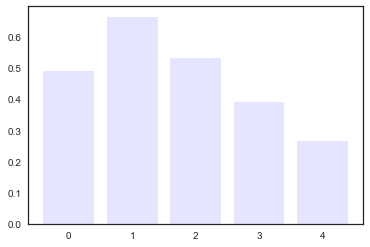

In [179]:
plt.bar(np.arange(K),softplus(inference.params['means']['alpha']), alpha=0.1, color='b')            

In [159]:
inference.params['means']['w']

array([ 12.61480304,  -0.55709769,  -8.35987147,  -4.96407977,   1.15052779])

In [160]:
w

array([ 0.44380324,  0.22508184,  0.1060261 , -1.29771196, -1.57457552])

In [161]:
alpha

array([ 1.,  1.,  1.,  1.,  1.])

In [162]:
softplus(inference.params['means']['alpha'])

array([ 0.67541544,  0.65739964,  0.66155811,  0.67742044,  0.63405342])